# Adult Census Income
### Predict whether income exceeds $50K/yr based on census data

#### we will try few algorithms to determine whether a person makes over $50K a year. 
## Our algorithm pipeline is as follow
* loading dataset
* Preprocessing
    * visualization and summary
    * imputation
    * normalization
    * splite the dataset
* algorithm development and representation
* Algorithm optimization
* Algorithm evaluation

In [362]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
sns.set_theme(style="ticks")

data_path = os.path.join(os.pardir, 'data')
dataset_name = "adult.csv"

# read the dataset
dataset = pd.read_csv(os.path.join(data_path, dataset_name))
dataset.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [361]:
# sns.pairplot(dataset, hue="income")

# plt.show()

In [352]:
# dataset shape
# (32561, 15)

# Y = dataset['income']
# X = dataset.drop(['income'], axis=1)

# XX = X.replace('?', np.NaN)
# XX.describe()
# dataset = dataset.replace('?', np.NaN)
dataset.describe()


AttributeError: 'numpy.ndarray' object has no attribute 'describe'

Count tell us if there's a missing data or not. All the numerical columns seems to have no missing data here. The mean and median tell us about the skewness in the data. For capital gain and capital loss, we can see that mean > median which happens when our data is right skewed. Rest of the columns seems fine. We can also say that our capital gain and capital loss are affected by outliers

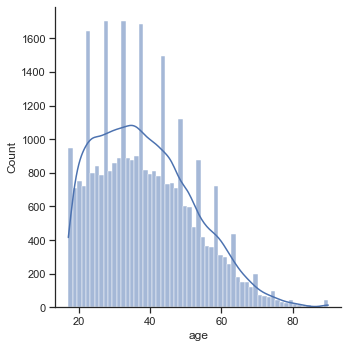

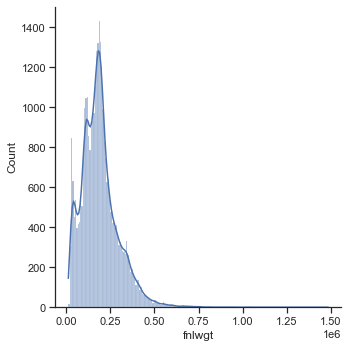

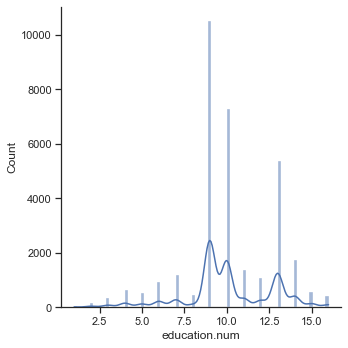

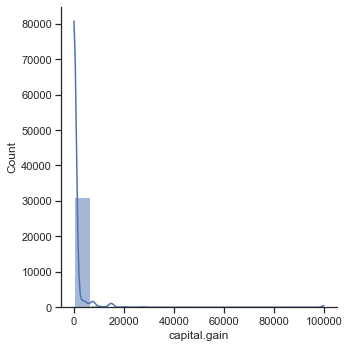

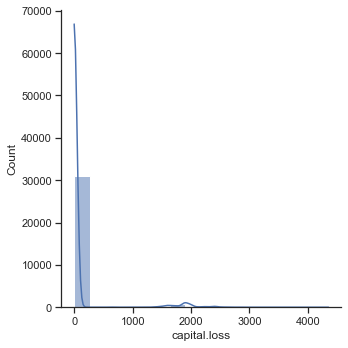

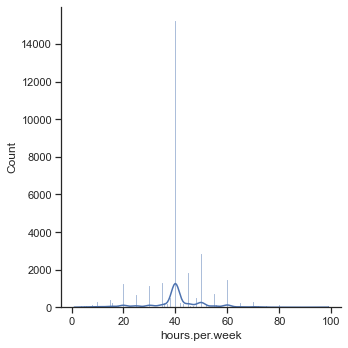

In [363]:
sns.displot(x=dataset['age'], kde=True)
sns.displot(x=dataset['fnlwgt'], kde=True)
sns.displot(x=dataset['education.num'], kde=True)
sns.displot(x=dataset['capital.gain'], kde=True)
sns.displot(x=dataset['capital.loss'], kde=True)
sns.displot(x=dataset['hours.per.week'], kde=True)

# Based on our visualization in previous snippet we will accoplish the following preprocessing to make our feature more informative
## group ages in different bins so each bin have enought number of samples 


## seperate categorical and numerical variables

In [364]:
numerical_var = [col for col in dataset.columns if dataset[col].dtype != object]
categorical_var = [col for col in dataset.columns if dataset[col].dtype == object]
# [(i, dataset[i].unique()) for i in categorical_var]

## encoding income
* 0 = income < \$50k
* 1 = income > $50k

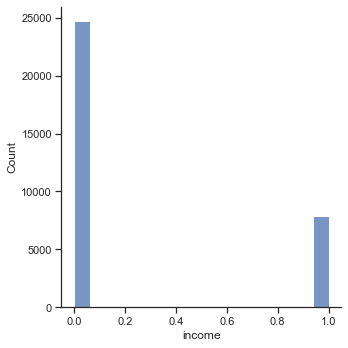

In [365]:
dataset['income'] = dataset['income'].apply(lambda x: x.replace("<=50K", '0'))
dataset['income'] = dataset['income'].apply(lambda x: x.replace(">50K", '1'))
dataset['income'] = dataset['income'].replace('0', 0)
dataset['income'] = dataset['income'].replace('1', 1)
sns.displot(dataset['income'])

<AxesSubplot:xlabel='workclass', ylabel='income'>

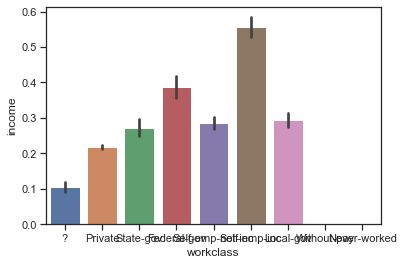

In [346]:
sns.barplot(x=dataset['workclass'], y=dataset['income'], data=dataset)

# plt.xticks(rotation = 90)

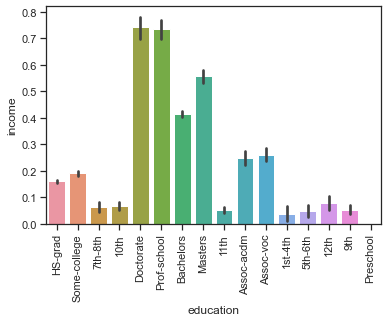

In [155]:
sns.barplot(x = dataset['education'], y = dataset['income'])
plt.xticks(rotation = 90);

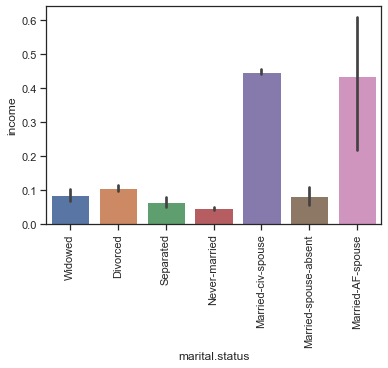

In [156]:
sns.barplot(x = 'marital.status', y = 'income', data = dataset)
plt.xticks(rotation = 90);

In [366]:
# age
for i in dataset:
    dataset.loc[(dataset['age'] > 16) & (dataset['age'] <= 25), 'age'] = 1
    dataset.loc[(dataset['age'] > 25) & (dataset['age'] <= 32), 'age'] = 2
    dataset.loc[(dataset['age'] > 32) & (dataset['age'] <= 40), 'age'] = 3
    dataset.loc[(dataset['age'] > 40) & (dataset['age'] <= 50), 'age'] = 4
    dataset.loc[dataset['age'] > 50, 'age'] = 5

# education
dataset['education'] = dataset['education'].apply(lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
                                              or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' 
                                              or x == 'Preschool' else x)
dataset['education'] = dataset['education'].apply(lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x)
education_map = {'School':1,
             'HS-grad':2,
             'Some-college':3,
             'Bachelors':4,
             'Prof-school':5,
             'Associate':6,
             'Masters':7,
             'Doctorate':8}
dataset['education'] = dataset['education'].map(education_map)

dataset['capital_diff'] = abs((dataset['capital.gain'] - dataset['capital.loss']))

dataset['marital.status'] = dataset['marital.status'].apply(lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x)
dataset['marital.status'] = dataset['marital.status'].apply(lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x)

# workclass
dataset['workclass'] = dataset['workclass'].apply(lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay'
                                            else x)

dataset[dataset == '?'] = np.nan

col_with_symbol = ['workclass', 'occupation', 'native.country']



# Cold-Deck Imputation

In [367]:
keys = dataset['workclass'].unique()
values = np.array([np.nan, 1, 2, 3, 4, 5, 6, 7])
map_data = dict(zip(keys, values))
dataset['workclass'] = dataset['workclass'].map(map_data)

keys = dataset['occupation'].unique()
values = np.array([np.nan, 1, 2, 3, 4, 5, 6,7, 8, 9,10, 11, 12,13, 14])
map_values = dict(zip(keys, values))
dataset['occupation'] = dataset['occupation'].map(map_values)


keys = dataset['native.country'].unique()
values = np.array(np.linspace(start=1, stop=len(keys), num=len(keys)))
values[1] = np.nan
map_values = dict(zip(keys, values))
dataset['native.country'] = dataset['native.country'].map(map_values)

keys = dataset['sex'].unique()
values = np.array(np.linspace(start=1, stop=len(keys), num=len(keys)))
map_values = dict(zip(keys, values))
dataset['sex'] = dataset['sex'].map(map_values)

keys = dataset['relationship'].unique()
values = np.array(np.linspace(start=1, stop=len(keys), num=len(keys)))
map_values = dict(zip(keys, values))
dataset['relationship'] = dataset['relationship'].map(map_values)

keys = dataset['marital.status'].unique()
values = np.array(np.linspace(start=1, stop=len(keys), num=len(keys)))
map_values = dict(zip(keys, values))
dataset['marital.status'] = dataset['marital.status'].map(map_values)

keys = dataset['race'].unique()
values = np.array(np.linspace(start=1, stop=len(keys), num=len(keys)))
map_values = dict(zip(keys, values))
dataset['race'] = dataset['race'].map(map_values)


def cosinSim(vec1, vec2):
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    cosin_sim = np.dot(vec1, vec2)/(vec1_norm *vec2_norm)
    return cosin_sim

def coldImputationE1(data):
    columns = ['age', 'fnlwgt', 'education', 'education.num',  
               'hours.per.week', 'hours.per.week', 'capital_diff']
    datanonullINDEX = data[data['workclass'].notnull()].index 
    datanullINDEX = dataset[dataset['workclass'].isnull()].index
    datanonull = data[data['workclass'].notnull()][columns]
    for i in datanullINDEX:
        vec1 = data.iloc[int(i)][columns].values
        candidate = {'replaceID': 0}
        temp = 0.
        for j in datanonullINDEX:
            vec2 = data.iloc[int(j)][columns].values
            v1_sim_v2 = 1
            if v1_sim_v2 > temp:
                temp = v1_sim_v2
                candidate['replaceID']= int(j)

        data.iloc[int(i)]['workclass'] = data.iloc[candidate['replaceID']]['workclass']
    
    return data
            
         
def coldImputationE2(data):   
    imputer = KNNImputer(n_neighbors=2, weights='uniform')
    datanew = imputer.fit_transform(data)
    return datanew


Y = dataset['income']
X = dataset.drop(['income'], axis=1)
X = coldImputationE2(X)



0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    0
32558    1
32559    0
32560    0
Name: income, Length: 32561, dtype: int64

In [383]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(f"Number of mislabeled points out of a total {X_test.shape[0]} points : {(y_test != y_pred).sum()}")
print(gnb.predict(X_test))
print(gnb.score(X_test, y_test))


Number of mislabeled points out of a total 6513 points : 1323
[0 0 0 ... 1 0 0]
0.7968678028558268


# Mean Imputation

In [318]:
def MeanImputation(data):
    pass
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
# impute.fit(dataset)
dataset

array([[5.00000e+00, 1.00000e+00, 7.70530e+04, ..., 1.00000e+00,
        0.00000e+00, 4.35600e+03],
       [5.00000e+00, 1.00000e+00, 1.32870e+05, ..., 1.00000e+00,
        0.00000e+00, 4.35600e+03],
       [5.00000e+00, 3.00000e+00, 1.86061e+05, ..., 1.00000e+00,
        0.00000e+00, 4.35600e+03],
       ...,
       [3.00000e+00, 1.00000e+00, 1.54374e+05, ..., 1.00000e+00,
        1.00000e+00, 0.00000e+00],
       [5.00000e+00, 1.00000e+00, 1.51910e+05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 2.01490e+05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

# Regression Imputation

In [319]:
def RegressionImputation(data):
    pass